In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
#%matplotlib qt

In [3]:
df = pd.read_excel("Coverage_Signal_Level_Prediction.xlsx")

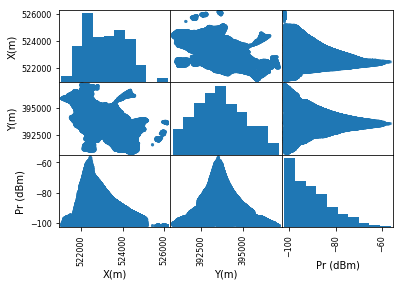

In [4]:
pd.plotting.scatter_matrix(df);

**On charge les données dans une structure dataframe pandas.**
- On commence une étude descriptive (statistique descriptive): on essaye alors de tracer les distributions des données. 
- Les histogrammes permettent d'avoir quelques informations basiques sur les données comme la valeur maximale, la valeur minimale, la forme de la distribution des données qui peut être liée aux processus stochastiques qui ont permis de créer les données.

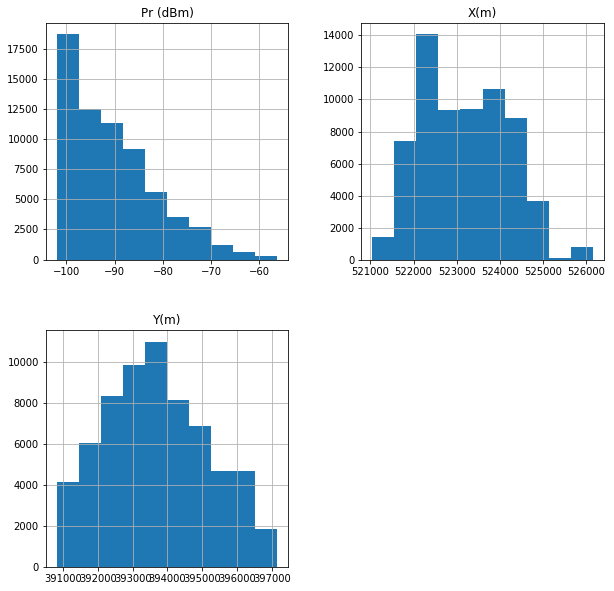

In [5]:
df.hist(figsize=(10,10));

**Remarques**:
- La distribution de puissance semble être une loi exponentielle décroissante.
- La distribution des Y semble être une loi normale générale. Pareil, pour la distribution des X.

- Maintenant, on essaye de déterminer les valeurs des quelques estimateurs statistiques basiques comme la moyenne, la médiane, l'écart-type...

In [6]:
df.describe()

,X(m),Y(m),Pr (dBm)
count,65712.000000,65712.000000,65712.000000
mean,523175.993899,393702.753159,-90.448841
std,988.049198,1485.870049,9.187064
min,521040.620000,390819.390000,-102.000000
25%,522351.117500,392575.637500,-98.000000
50%,523127.145000,393619.950000,-92.125000
75%,523957.172500,394779.292500,-85.187500
max,526160.440000,397163.700000,-56.250000


In [7]:
abs( ( df.mean()   - df.median() ) / df.mean()       ) * 100

X(m)        0.009337
Y(m)        0.021032
Pr (dBm)    1.853157
dtype: float64

**On trace la distribution des points aberrants**

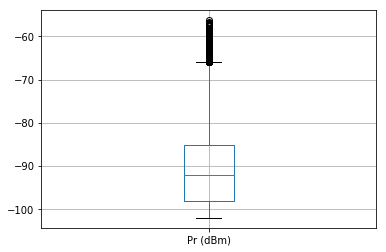

In [8]:
df[["Pr (dBm)"]].boxplot();

**On continue à tracer quelques graphes représentant les données permettant de bien comprendre les modèles de prédiction qui seront utilisés après pendant la période de modélisation**

In [9]:
X = df.iloc[:,0].values
Y = df.iloc[:,1].values
Puissance = df.iloc[:,2].values

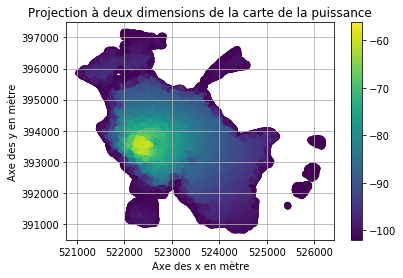

In [10]:
plt.scatter(X,Y,c=Puissance);
plt.xlabel("Axe des x en mètre")
plt.ylabel("Axe des y en mètre")
plt.title("Projection à deux dimensions de la carte de la puissance")
plt.colorbar()
plt.grid()

- **La projection à deux dimensions montre l'existence d'une concentration de puissance de grandes valeurs à gauche. En fait, c'est comme, une gaussienne en 2D qui se trouve centrée au niveau de la région coloriée en jaune!**


- **Cette représentation va nous permettre après de bien initialiser les algorithmes d'optimisation qui vont chercher les 5 paramètres définissant cette gaussienne en 2D et qui sont la valeur moyenne par rapport sur l'axe des x, la valeur moyenne sur l'axe des y, l'écart-type sur l'axe des x, l'écart-type sur l'axe des y et l'amplitude de la gaussienne.**

- **Maintenant, nous avons besoin de représenter la gaussienne en trois dimensions**

In [11]:
from mpl_toolkits.mplot3d import Axes3D

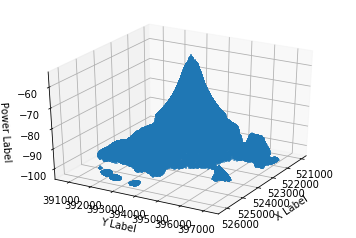

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Puissance, marker="+")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Power Label')
ax.view_init(elev=30, azim=30)
plt.show()

- **Quand on trace la totalité des points, on n'arrive pas bien à voir la distribution. A cet égard, on va diminuer le nombre des points tracés**

- **En fait, on est en train de diminuer la résolution spatiale**

- **Essayons avec 1 km**

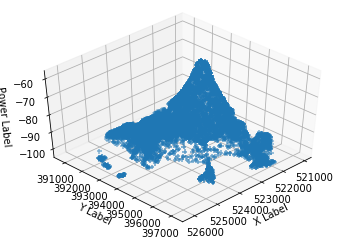

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[::10], Y[::10], Puissance[::10], marker="+")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Power Label')
ax.view_init(elev=45, azim=45)
plt.show()

- **1 km c'est beaucoup, essayons avec une précision spatiale de 100 mètres**

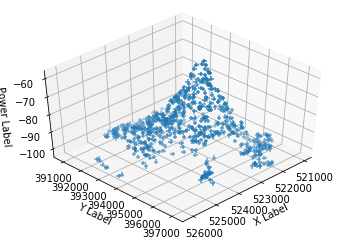

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[::100], Y[::100], Puissance[::100], marker="+")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Power Label')
ax.view_init(elev=45, azim=45)
plt.show()

- **Il est clair qu'il s'agit d'une distribution en 3D pyramidale.**

- **Sachons qu'on connait pas la loi physique permettant de créer cette distribution spatiale de puissance.**

- **On peut penser à un plan mais bien évidemment c'est faux.**

- **D'un point de vue machine learning, le choix d'un plan peut être justifié: un data scientist qui n'a pas des connaissances dans un domaine métier en l'occurrence la télécommunication, peut ajuster la distribution des points par n'importe quelle forme géométrique!**

- **On va remarquer pendant l'évaluation de l'ajustement de la distribution par un plan que le coefficient de détermination $R^2$ est très mauvais c'est-à-dire proche de 0**

- **Stratégie de la modélisation:**

- Si on ne connaît pas la loi physique: on peut ajuster par un plan (un modèle multi-linéaire simple.

- On peut penser aux algorithmes de classification comme knn, random forest, support vector machine, Naive Bayes, Arbre de décision (decision tree) mais utilisés en mode regressor. Eh oui! on peut utiliser ces algorithmes de classification pour réaliser des régressions numériques dans le cas où le modèle mathématique n'est pas connu à l'avance.

- D'après notre analyse descriptive, on peut ajuster la distribution par une gaussienne à deux dimensions. On parle alors d'un problème d'optimisation non linéaire.

- Sinon, on peut effectuer une interpolation à 3 dimensions.

- Finalement, on peut utiliser les réseaux de neuronnes et donc de deep learning. On applique les algorithmes de reconnaissance d'images.


### Ajustement par un plan:

- On va essayer le modèle directement sur les données brutes puis on va évaluer le modèle sur les données tests.

- Feature Engineering: Data rescaling avec un standard scaler puis on va réaliser un échantillonnage aléatoire pendant l'étape de splitting des données en train dataset et test dataset.

- Application d'un modèle multilinéaire.

- Evaluation finale.

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
Z = np.zeros((X.shape[-1],2))
Z[:,0] = X
Z[:,1] = Y

In [17]:
Z_train, Z_test, P_train, P_test = train_test_split(Z,Puissance,random_state=40,test_size=0.2)

In [18]:
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()

In [19]:
# Ajustement multilinéaire
model1.fit(Z_train,P_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [20]:
# Evaluation sur les données d'entrainement (attention il ne s'agit pas de la vraie évaluation)
model1.score(Z_train,P_train)

0.06152784806461664

Déjà sur les données d'entrainement, le modèle multilinéaire du plan ne donne pas des bons résultats. Essayons maintenant sur les données test.

In [21]:
# Evaluation sur les données test
model1.score(Z_test,P_test)

0.063627505826785

In [22]:
# Essayons d'améliorer les résultats avec la remise à l'échelle des données (rescaling)
from sklearn.preprocessing import StandardScaler
ssx = StandardScaler()
ssy = StandardScaler()
ssp = StandardScaler()

In [23]:
X_ss = ssx.fit_transform(X.reshape(-1,1))
Y_ss = ssy.fit_transform(Y.reshape(-1,1))
P_ss = ssp.fit_transform(Puissance.reshape(-1,1))

In [24]:
Z1 = np.zeros((X.shape[-1],2))
Z1[:,0] = X_ss.reshape(X_ss.shape[0])
Z1[:,1] = Y_ss.reshape(X_ss.shape[0])

In [25]:
Z_train, Z_test, P_train, P_test = train_test_split(Z1,P_ss,random_state=40,test_size=0.2)

In [26]:
from sklearn.linear_model import LinearRegression
model2 = LinearRegression()

In [27]:
# Ajustement multilinéaire
model2.fit(Z_train,P_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [28]:
# Evaluation sur les données d'entrainement (attention il ne s'agit pas de la vraie évaluation)
model2.score(Z_train,P_train)

0.0615278480646162

In [29]:
# Evaluation sur les données test
model1.score(Z_test,P_test)

-2416057.0333124488

- **Voilà, le rescaling dans le cas d'un modèle linéaire ne change rien. On obtient le score sur les données brutes et sur les données remises à l'échelle.**


### Traçage du plan avec les données

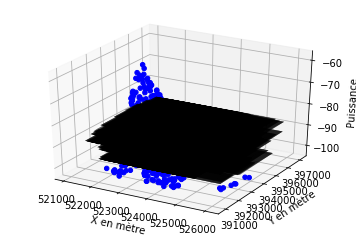

In [30]:
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# generate mesh
x_surf, y_surf = np.meshgrid(X[::1000], Y[::1000])

Z = np.zeros((X.shape[-1],2))
X1 = np.arange(X.min(),X.max(),1.1753489439852958)
Y1 = np.arange(Y.min(),Y.max(),1.4564531680440767)

Z = np.zeros((X1.shape[-1],2))
Z[:,0] = X1
Z[:,1] = Y1

out = model1.predict(Z)
ax.plot_surface(x_surf, y_surf,
                out.reshape(x_surf.shape),
                rstride=1,
                cstride=1,
                color='None',
                alpha = 0.4)

ax.scatter(X[::100], Y[::100], Puissance[::100],
           c='blue',
           marker='o',
           alpha=1)

ax.set_xlabel('X en mètre')
ax.set_ylabel('Y en mètre')
ax.set_zlabel('Puissance')

plt.show()

In [31]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

In [32]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(Z_train, P_train)  #fit the model
    pred=model.predict(Z_test) #make prediction on test set
    error = sqrt(mean_squared_error(P_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.03056553667223847
RMSE value for k=  2 is: 0.02239508954924673
RMSE value for k=  3 is: 0.0210380762089138
RMSE value for k=  4 is: 0.021056259680387025
RMSE value for k=  5 is: 0.021686297772556474
RMSE value for k=  6 is: 0.021958539861235048
RMSE value for k=  7 is: 0.022679644499734728
RMSE value for k=  8 is: 0.023106875491947024
RMSE value for k=  9 is: 0.02384140350524841
RMSE value for k=  10 is: 0.024396652066502274
RMSE value for k=  11 is: 0.025273853829276837
RMSE value for k=  12 is: 0.026131598371197905
RMSE value for k=  13 is: 0.026897138344529028
RMSE value for k=  14 is: 0.027645066659604298
RMSE value for k=  15 is: 0.02850142404350061
RMSE value for k=  16 is: 0.029265097353192555
RMSE value for k=  17 is: 0.02996291712824265
RMSE value for k=  18 is: 0.03073955651345816
RMSE value for k=  19 is: 0.031537138546828325
RMSE value for k=  20 is: 0.032326237304620704


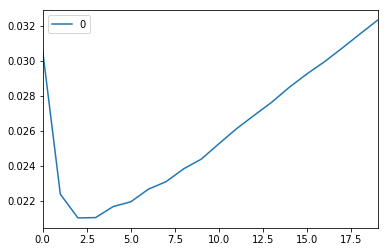

In [33]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot();

In [34]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(Z_train,P_train)
model.best_params_

{'n_neighbors': 4}

In [35]:
model3 = neighbors.KNeighborsRegressor(n_neighbors = 4)


In [36]:
 model3.fit(Z_train, P_train)  #fit the model

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=4, p=2,
          weights='uniform')

In [37]:
pred=model.predict(Z_test) #make prediction on test set

In [38]:
error = sqrt(mean_squared_error(P_test,pred)) #calculate rmse
print(error)

0.021056259680387025


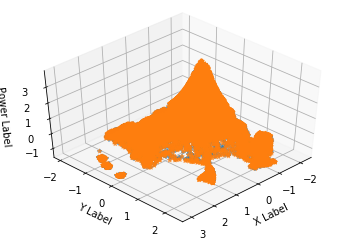

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z_test[:,0], Z_test[:,1], pred, marker="+")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Power Label')
ax.view_init(elev=45, azim=45)

ax.scatter(Z_test[:,0], Z_test[:,1], P_test, marker="*")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Power Label')
ax.view_init(elev=45, azim=45)
plt.show()



### Ajustement avec une gaussienne à deux dimensions

- 

In [40]:
from scipy.optimize import curve_fit

In [41]:
def gaussian_2d(xy_mesh, amp, xc, yc, sigma_x, sigma_y):
    
    # unpack 1D list into 2D x and y coords
    (x, y) = xy_mesh
    
    # make the 2D Gaussian matrix
    gauss = amp*np.exp(-((x-xc)**2/(2*sigma_x**2)+(y-yc)**2/(2*sigma_y**2)))/(2*np.pi*sigma_x*sigma_y)
    
    # flatten the 2D Gaussian down to 1D
    return np.ravel(gauss)

In [42]:
from sklearn.preprocessing import StandardScaler
X_ss = ssx.fit_transform(X.reshape(-1,1))
Y_ss = ssy.fit_transform(Y.reshape(-1,1))

xy_mesh = np.meshgrid(X_ss[::10],Y_ss[::10])
Puissance_positive = (-1) * np.array(list(Puissance[::10]) * 6572)

In [ ]:
# define some initial guess values for the fit routine
guess_vals = [60, X_ss.mean(), Y_ss.mean(), X_ss.std(), Y_ss.std()]
 
# perform the fit, making sure to flatten the noisy data for the fit routine 
fit_params, cov_mat = curve_fit(gaussian_2d, xy_mesh, Puissance_positive, p0=guess_vals, maxfev=5000)
 
# calculate fit parameter errors from covariance matrix
fit_errors = np.sqrt(np.diag(cov_mat))
 
## manually calculate R-squared goodness of fit
#fit_residual = Puissance_positive - gaussian_2d(xy_mesh, *fit_params).reshape(np.outer(X_ss[::100],Y_ss[::100]).shape)
#fit_Rsquared = 1 - np.var(fit_residual)/np.var(Puissance_positive)
 
#print('Fit R-squared:', fit_Rsquared, '\n')
print('Fit Amplitude:', fit_params[0], '\u00b1', fit_errors[0])
print('Fit X-Center: ', fit_params[1], '\u00b1', fit_errors[1])
print('Fit Y-Center: ', fit_params[2], '\u00b1', fit_errors[2])
print('Fit X-Sigma:  ', fit_params[3], '\u00b1', fit_errors[3])
print('Fit Y-Sigma:  ', fit_params[4], '\u00b1', fit_errors[4])

In [ ]:
xy_mesh[0].shape